# SVM

## import packages

In [1]:
import tensorflow
import numpy as np
import os
import time
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

## load data

In [2]:
pianist = "XXX"
filepath = "dataset/piano/bach/bach1/"
#Getting midi files
all_midis = []
for i in os.listdir(filepath):
    print("Use music file: ", i)
    if i.endswith(".mid") or i.endswith(".MID"):
        tr = filepath + i
        midi = converter.parse(tr)
        all_midis.append(midi)

Use music file:  .DS_Store
Use music file:  bach_846.mid


Total notes in all the Debussy midis in the dataset: 1263
First fifty values in the Debussy: ['C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'C4', 'E4']
Total unique notes in the XXX: 54
Average recurrenc for a note in XXX: 23.38888888888889
Most frequent note in XXX appeared: 104 times
Least frequent note in XXX appeared: 1 time


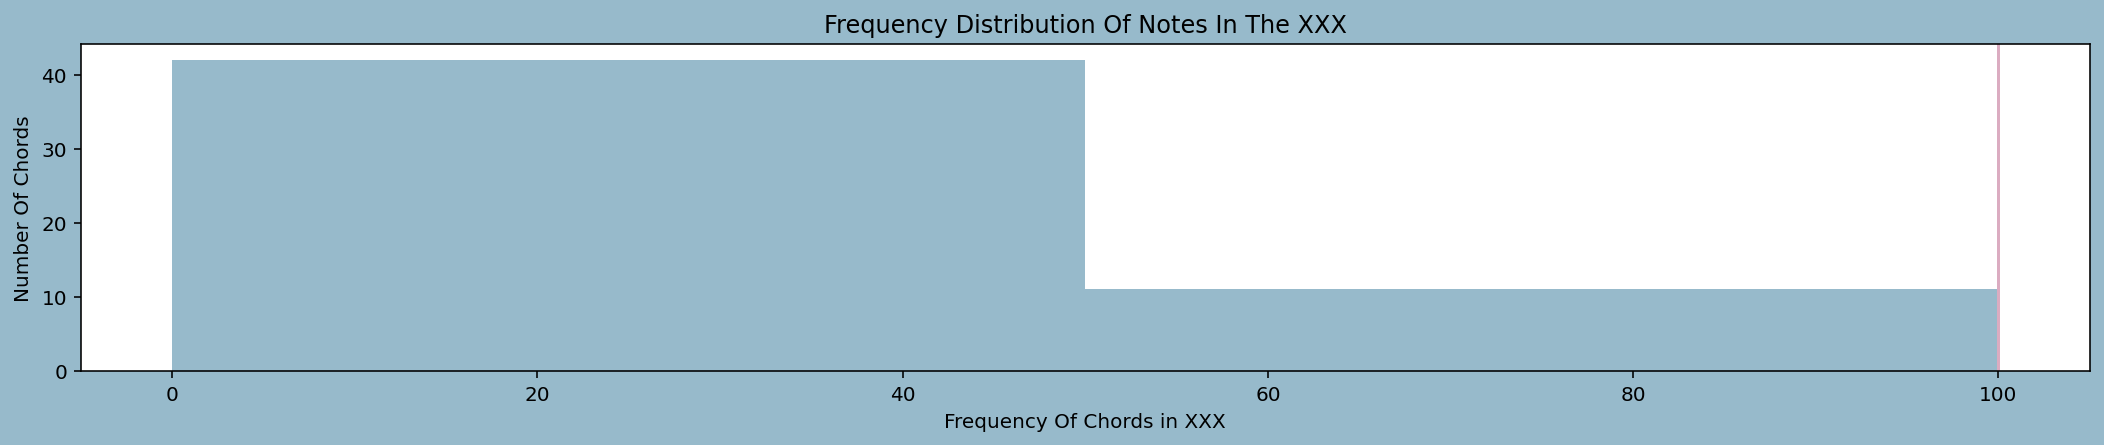

In [3]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

#Getting the list of notes as Corpus
debussy = extract_notes(all_midis)
print("Total notes in all the Debussy midis in the dataset:", len(debussy))
print("First fifty values in the Debussy:", debussy[:50])


def chords_n_notes(Snippet):
    Melody = []
    offset = 0  #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")  #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi


Melody_Snippet = chords_n_notes(debussy[:100])
# show(Melody_Snippet)
#Creating a count dictionary
debussy_num = Counter(debussy)
print("Total unique notes in the {0}:".format(pianist), len(debussy_num))
Notes = list(debussy_num.keys())
Recurrence = list(debussy_num.values())


#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)


print("Average recurrenc for a note in {0}:".format(pianist), Average(Recurrence))
print("Most frequent note in {0} appeared:".format(pianist), max(Recurrence), "times")
print("Least frequent note in {0} appeared:".format(pianist), min(Recurrence), "time")
# Plotting the distribution of Notes
plt.figure(figsize=(18, 3), facecolor="#97BACB")
bins = np.arange(0, (max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100, color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The {0}".format(pianist))
plt.xlabel("Frequency Of Chords in {0}".format(pianist))
plt.ylabel("Number Of Chords")
plt.show()


In [4]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(debussy_num.items()):
    if value < 100:
        m = key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))
#Eleminating the rare notes
for element in debussy:
    if element in rare_note:
        debussy.remove(element)
print("Length of {0} after elemination the rare notes:".format(pianist), len(debussy))

Total number of notes that occur less than 100 times: 53
Length of XXX after elemination the rare notes: 666


## data processing

In [5]:
symb = sorted(list(set(debussy)))

L_corpus = len(debussy)  #length of corpus
L_symb = len(symb)  #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

length = 70  # the number of features
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = debussy[i:i + length]
    target = debussy[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Total number of sequences in the {0}:".format(pianist), L_datapoints)


Total number of characters: 666
Number of unique characters: 45
Total number of sequences in the XXX: 596


In [6]:
# reshape X and normalize
# X = (np.reshape(features, (L_datapoints, length, 1))) / float(L_symb)
# X = (np.reshape(features, (L_datapoints, length))) / float(L_symb)
X = np.reshape(features, (L_datapoints, length))
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

#Taking out a subset of data to be used as seed
X_train0, X_seed0, y_train0, y_seed0 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_seed, y_train, y_seed = train_test_split(X, np.array(targets), test_size=0.2, random_state=42)

In [7]:
num_notes = len(debussy_num)
num_notes

54

## Build SVM model

### SVM loss and gradient function

$$
L_i = \sum_{j\neq y_i} max(0, w_j^{T}x_i - w_{y_i}^Tx_i + \Delta)\\
where\  \Delta=1
$$

$$
L = \frac{1}{N} \sum_{i=1}^{N} L_i\\
\text{where N is the number of samples}
$$

In [8]:
def svm_loss(weight, x, y, reg=0.0005):
    loss = 0
    dw = np.zeros(weight.shape)  # initialize the gradient as 0
    num_train = x.shape[0]  # the number of samples
    scores = x.dot(weight)
    # selecting specific column index
    yi_scores = scores[np.arange(scores.shape[0]), y]  # the right scores
    margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
    margins[np.arange(num_train), y] = 0
    loss = np.mean(np.sum(margins, axis=1))
    loss += reg * np.sum(weight * weight)
    # compute the gradient
    binary = margins
    binary[margins > 0] = 1
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(num_train), y] = -row_sum.T
    dw = np.dot(x.T, binary)
    dw /= num_train
    dw += reg * weight  # regularize
    return loss, dw

In [9]:
w = np.random.randn(length, num_notes)  # generate a random SVM weight matrix of small numbers
loss, _ = svm_loss(w, X_train, y_train)
print("training loss = %f" % (loss))

training loss = 6987.582266


### gradient check

To check whether we have implemented the gradient correctly, the gradient of the loss function is estimated and the mathematical estimate is compared with the calculated gradient.

**Because gradient checking is very computationally intensive, here we only perform 8 gradient checking.**

In [10]:
def grad_check_8(f, x, analytic_grad, num_checks=8, h=1e-5):
    for i in range(num_checks):
        # random choose some data points
        ix = tuple([random.randrange(m) for m in x.shape])
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h  # increment by h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (
                abs(grad_numerical) + abs(grad_analytic)
        )
        print(
            "numerical: %f analytic: %f, relative error: %e"
            % (grad_numerical, grad_analytic, rel_error)
        )

In [11]:
loss, grad = svm_loss(w, X_train, y_train, 5e1)
f = lambda k: svm_loss(k, X_train, y_train, 5e1)[0]
grad_num = grad_check_8(f, w, grad)

numerical: 107.530036 analytic: 61.568590, relative error: 2.718026e-01
numerical: -123.669516 analytic: -64.628876, relative error: 3.135483e-01
numerical: 70.957630 analytic: 40.851714, relative error: 2.692612e-01
numerical: -9.952532 analytic: -8.399585, relative error: 8.461949e-02
numerical: -40.135821 analytic: -26.803205, relative error: 1.991755e-01
numerical: -53.721629 analytic: -28.374470, relative error: 3.087499e-01
numerical: 31.148907 analytic: 21.469412, relative error: 1.839568e-01
numerical: 14.937764 analytic: 15.106487, relative error: 5.615836e-03


In [12]:
tic = time.time()
loss, _ = svm_loss(weight=w, x=X_train, y=y_train)
toc = time.time()
print("Loss computed in %f s" % (toc - tic))

Loss computed in 0.024391 s


### softmax classifier (multi logistic regression)

In [13]:
def softmax_loss(W, X, y, reg):
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    scores = X.dot(W)
    scores = scores - np.max(scores, axis=1, keepdims=True)
    # Softmax Loss
    sum_exp_scores = np.exp(scores).sum(axis=1, keepdims=True)
    softmax_matrix = np.exp(scores) / sum_exp_scores
    loss = np.sum(-np.log(softmax_matrix[np.arange(num_train), y]))
    # Weight Gradient
    softmax_matrix[np.arange(num_train), y] -= 1
    dW = X.T.dot(softmax_matrix)
    # Average
    loss /= num_train
    dW /= num_train
    # Regularization
    loss += reg * np.sum(W * W)
    dW += reg * 2 * W
    return loss, dW

### create classes

In [14]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        num_train, dim = X.shape
        num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)
        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None
            random_idxs = np.random.choice(num_train, batch_size)
            X_batch = X[random_idxs]
            y_batch = y[random_idxs]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update

            self.W -= learning_rate * grad
            if verbose and it % 1000 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        y_pred = np.zeros(X.shape[1])
        y_pred = np.argmax(np.dot(X, self.W), axis=1)
        return y_pred

    def predict_scores(self, X):
        scores = np.dot(X, self.W)
        return scores

    def loss(self, X_batch, y_batch, reg):
        pass


class LinearSVM(LinearClassifier):
    def loss(self, X_batch, y_batch, reg):
        return svm_loss(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    def loss(self, X_batch, y_batch, reg):
        return softmax_loss(self.W, X_batch, y_batch, reg)

## Train a svm model

### start training

In [24]:
linear_svm1 = LinearSVM()
start_time = time.time()
loss_hist = linear_svm1.train(X_train, y_train, learning_rate=1e-4, reg=3e-9, num_iters=10000, verbose=True)
end_time = time.time()
print("It took %f s" % (end_time - start_time))

iteration 0 / 10000: loss 44.667860
iteration 1000 / 10000: loss 1.990919
iteration 2000 / 10000: loss 1.300625
iteration 3000 / 10000: loss 1.104513
iteration 4000 / 10000: loss 1.030563
iteration 5000 / 10000: loss 0.804949
iteration 6000 / 10000: loss 0.691549
iteration 7000 / 10000: loss 1.018512
iteration 8000 / 10000: loss 0.588422
iteration 9000 / 10000: loss 0.564294
It took 6.139537 s


## evaluate

### plot the loss history

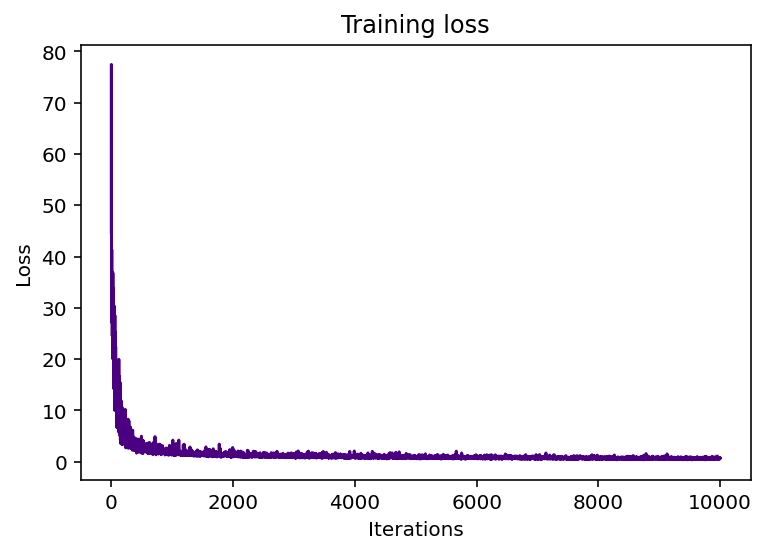

In [25]:
plt.Figure(figsize=(20, 8), dpi=100)
plt.plot(loss_hist, color="#4B0082")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()

### check the accuracy

In [26]:
y_pred = linear_svm1.predict(X_train)
print("Training accuracy = %f" % (np.mean(y_train == y_pred)))

Training accuracy = 0.831933


In [18]:
len(y_seed)

120

In [19]:
def Malody_Generator(svm_model, Note_Count):
    # seed = X_seed0[np.random.randint(0, len(X_seed0) - 1)]
    seed = X_seed[70]
    Music = []
    Notes_Generated = []
    for i in range(Note_Count):
        seed = seed.reshape(1, length)      # 1 × 40
        # prediction = svm_model.predict_scores(seed)
        index = svm_model.predict(seed)
        index_N = index / float(L_symb)
        Notes_Generated.append(index)
        # print(index)
        # Music = [reverse_mapping[char] for char in Notes_Generated]
        Music.append(reverse_mapping[index[0]])
        seed = np.insert(seed[0], len(seed[0]), index_N)
        seed = seed[1:]
    # #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    print(Music)
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music, Melody_midi

#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(linear_svm1, 25)
# Melody.write('midi','Melody_Generated.mid')
#to play audio or corpus
fname = "bach_850"
filename = fname.strip(".mid") + "_seed2.mid"
print(filename)
Melody.write("midi", filename)

['E3', 'A3', 'G4', 'D4', '0.2', 'D4', 'G4', 'E4', 'B3', 'A3', 'G4', 'D3', 'C3', 'A4', 'E4', 'D4', 'E4', 'D4', 'E4', 'E4', 'E4', 'A3', 'E4', 'A4', 'E4']
bach_850_seed2.mid


'bach_850_seed2.mid'